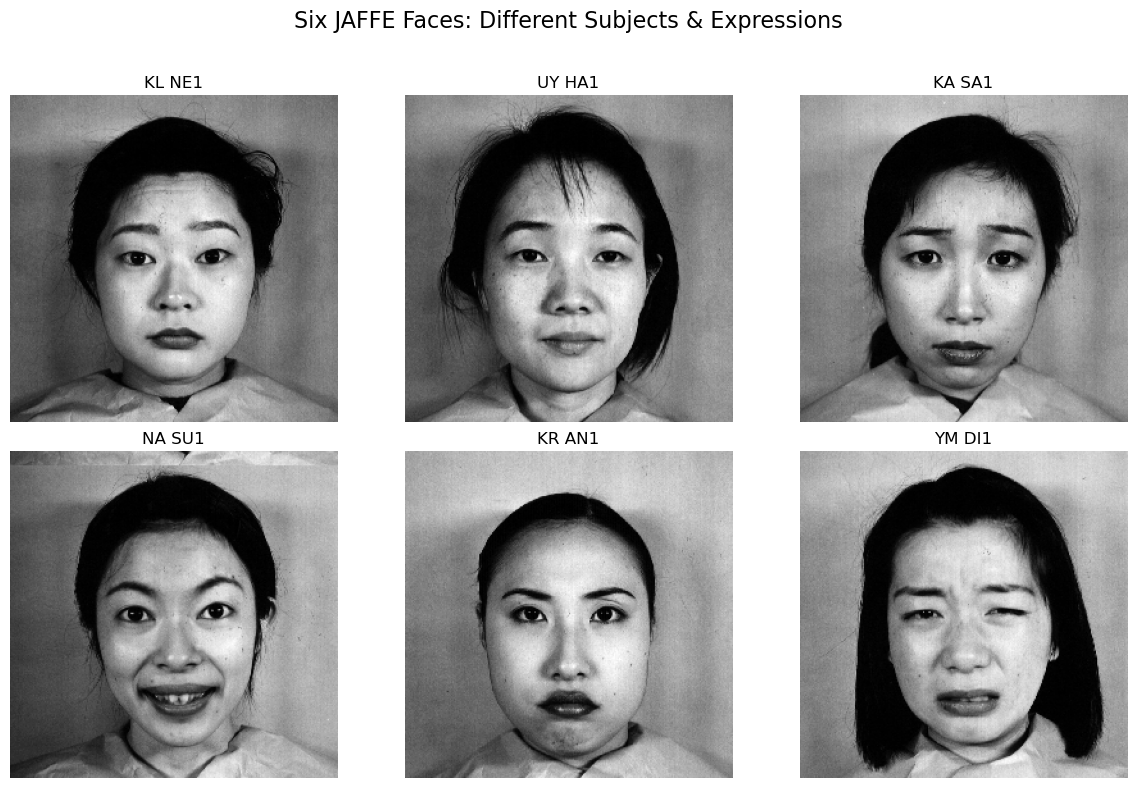

In [8]:
import os, glob
from PIL import Image
import matplotlib.pyplot as plt

# 1) Adjust to your local JAFFE folder
IMG_DIR = "/home/kleon/Desktop/epfl/langevinOT_sem_project/code/num_experiments/jaffe/jaffe/"

# 2) Build filename dictionary
paths = glob.glob(os.path.join(IMG_DIR, "*.tiff"))
jaffe_images = {}
for p in paths:
    fn = os.path.basename(p)
    root, _ = os.path.splitext(fn)     
    subject, rest = root.split('.', 1)  
    expr_pose, img_id = rest.split('.') 
    expr = expr_pose[:2]                
    pose = expr_pose[2:]                
    jaffe_images\
      .setdefault(subject, {})\
      .setdefault(expr, {})\
      .setdefault(pose, {})[img_id] = p

# 3) Choose 6 distinct expressions, enforcing distinct subjects
sentiments = ["NE","HA","SA","SU","AN","DI"]
selected = []
used_subjects = set()

for sent in sentiments:
    for subj, exprs in jaffe_images.items():
        if subj in used_subjects:
            continue
        if sent in exprs and "1" in exprs[sent]:
            img_id = sorted(exprs[sent]["1"])[0]
            path   = exprs[sent]["1"][img_id]
            selected.append((subj, sent, "1", path))
            used_subjects.add(subj)
            break
    else:
        raise ValueError(f"No unused subject found for expression {sent!r}")

# 4) Display in a 2×3 grid
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for ax, (subj, sent, pose, path) in zip(axes, selected):
    img = Image.open(path)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{subj} {sent}{pose}", fontsize=12)
    ax.axis("off")

plt.suptitle("Six JAFFE Faces: Different Subjects & Expressions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [14]:
import numpy as np
import os, sys

# compute the path to the parent folder (project/code)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from EM import euler_maruyama_coupling

# Load the six images and labels
images = []
labels = []
for subj, sent, pose, path in selected:
    img = np.array(Image.open(path).convert('L'), dtype=float)
    images.append(img)
    labels.append(f"{subj}_{sent}{pose}")

n = len(images)

# ------------------------------------------------------------------
# 3) Build discrete measures (pixel intensity histogram)
# ------------------------------------------------------------------
measures = []
for img in images:
    flat = img.ravel()
    hist = flat / flat.sum()     # normalize to sum 1
    measures.append(hist)

# ------------------------------------------------------------------
# 4) Pixel positions for the 2D grid
# ------------------------------------------------------------------
H, W = images[0].shape
xs, ys = np.meshgrid(np.arange(W), np.arange(H))
pixel_positions = np.column_stack((xs.ravel(), ys.ravel()))  # shape (H*W, 2)

# ------------------------------------------------------------------
# 5) Pairwise EM-W2 computation
# ------------------------------------------------------------------
Ns     = 2000
epsilon = 1e-3
T       = 3.0
Nsteps  = 500

W2 = np.zeros((n, n))
for i in range(n):
    for j in range(i, n):
        mu = measures[i]
        nu = measures[j]
        # sample indices by histogram
        idx_i = np.random.choice(len(mu), size=Ns, p=mu)
        idx_j = np.random.choice(len(nu), size=Ns, p=nu)
        # map to positions
        X0 = pixel_positions[idx_i]
        Y0 = pixel_positions[idx_j]

        # run Euler–Maruyama coupling
        errs, X_traj, Y_traj, _ = euler_maruyama_coupling(
            X0, Y0,
            epsilon=epsilon, T=T, N=Nsteps,
            cond_method='nadaraya', h=0.01,
            grad_U=grad_U, grad_V=grad_V,
            seed=42
        )
        dist = np.sqrt(errs[-1])
        W2[i, j] = dist
        W2[j, i] = dist

# ------------------------------------------------------------------
# 6) Plot the 6×6 heatmap
# ------------------------------------------------------------------
plt.figure(figsize=(6,6))
plt.imshow(W2, cmap='viridis')
plt.colorbar(label=r'$W_2$ distance')
plt.xticks(range(n), labels, rotation=45, ha='right')
plt.yticks(range(n), labels)
plt.title("Pairwise $W_2$ distances for 6 selected JAFFE faces")
plt.tight_layout()
plt.show()

NameError: name 'grad_U' is not defined